In [ ]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

# A/B test and test Power

Sometimes we hear statistical test results state that the "Null hypothesis is rejected at the chosen significance level". We trust the statement and move on. But is the conclusion corect? Maybe we rejected the Null and it was True, so we shouldn't have rejected it. It is natural to ask ourselves, what is the probability that the Null is rejected when it is in fact False? If that probability is high, I'm reasonably sure that the Null rejection was the right choice. To answer this question we need to calculate the **Power** of our test.

The **Power** of a test is the probability of rejecting the Null hypothesis when it is in fact false (or when the alternative is true). In the context of A/B tests, the power is the ability of the test to correctly detect a difference between A and B, that is, there is really a statistically significant difference.

Power analysis is appropriate when we are concerned with Type 2 errors (or false negatives). In our case, we don't want to make the mistake of switching from A to B when the version B isn't actually benefiting us. If we detect an effect that doesn't exist, not only we may switch to B without any gain but the version B may actually lead to worse results than A.

In the following we consider a two sample test concerning two conversion rates (proportions), which are the number of users that generate a conversion with respect to total users in their respective group.

## Normal distribution approximation of the binomial distribution
The Binomial distribution can be approximated with a normal distribution if the sample size is sufficiently large (see the post on the [Central Limit Theorem](https://github.com/FullSimplify/Examples/blob/master/CLT_binomial.ipynb)). For example if $np$ amd $n(1-p)$ are both greater than 5 then the approximation is justified. In our case we can use the approximation. The normal distribution will then be $\mathcal{N}\bigg(np, np(1-p)\bigg)$.
Let us plot again the binomial distributions with the normal approximations.

In [ ]:
def abplot(n_A, n_B, dist_A, dist_B, signif_level):
  loc_A, sigma_A = dist_A.stats()
  loc_B, sigma_B = dist_B.stats()

  p_A = loc_A/n_A
  p_B = loc_B/n_B

  f, ax = plt.subplots(1, 1, figsize=(12, 6))
  
  # x_A = np.arange(stats.binom.ppf(0.00001, n_A, loc_A/100), stats.binom.ppf(0.99999, n_A, loc_A/100))
  # ax.plot(x_A, stats.binom(n_A, loc_A).pmf(x_A), label='binomial B') 
  
  x = np.linspace(dist_A.ppf(0.00001), dist_A.ppf(0.99999), 200)
  ax.plot(x, dist_A.pdf(x), label='pdf A')  # the .pdf is actally a density, it integrates to 1
  ax.axvline(loc_A, lw=1, ls='--')

  x = np.linspace(dist_B.ppf(0.00001), dist_B.ppf(0.99999), 200)
  ax.plot(x, dist_B.pdf(x), label='pdf B')  
  ax.axvline(loc_B, lw=1, ls='--', color="darkorange")

  ax.axvline(dist_A.ppf(1-signif_level), color='k', lw=1.5, ls='--', label=r"crit. value $\alpha$ = 0.5")

  argmin = np.argmin(np.abs(dist_A.ppf(1 - signif_level) - x))
  power = np.trapz(dist_B.pdf(x)[argmin:], x[argmin:])
  ax.fill_between(x[argmin:], dist_B.pdf(x)[argmin:], alpha=0.4, color="darkorange")

  # based on the SE of difference between proportions
  se = np.sqrt(p_A * n_A + p_B * n_B)  # 
  diff = np.abs(p_A - p_B)
  # effect_size = p_B/n_B - p_A/n_A
  effect_size = diff/se
  rel_abs_effect = np.abs(p_A - p_B)/p_A
  # plt.title("Power (shaded) = {:1.3f}. Pooled Effect Size = {:1.3f}, Signif. Level = {:1.3f}"
  # .format(np.trapz(dist_B.pdf(x)[argmin:], x[argmin:]), effect_size, signif_level), fontsize=16)
  plt.title("Power (shaded) = {:1.3f}. Rel. Effect Size = {:1.3f}, Signif. Level = {:1.3f}"
  .format(np.trapz(dist_B.pdf(x)[argmin:], x[argmin:]), rel_abs_effect, signif_level), fontsize=16)
  ax.legend(fontsize=16);

  ax.set_ylabel("pdf", fontsize=16)

  return power

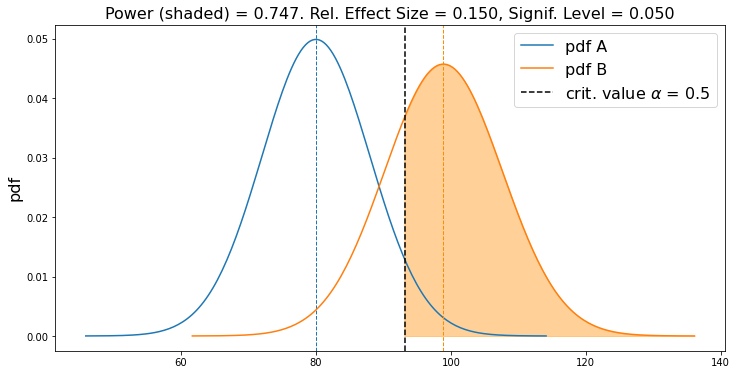

In [ ]:
# number of samples in each group
n_A = 400
n_B = 430

# proportions = conversion rates
# 15% relative effect size
p_A = .2  # 20% baseline cr
p_B = .23

# significance level
signif_level = 0.05

# normal approximation for a binomial
sigma_A = np.sqrt(n_A * p_A * (1 - p_A))
sigma_B = np.sqrt(n_B * p_B * (1 - p_B))

# distributions of conversion rates
norm_A = stats.norm(loc=p_A * n_A, scale=sigma_A) 
norm_B = stats.norm(loc=p_B * n_B, scale=sigma_B) 

_ = abplot(n_A, n_B, norm_A, norm_B, signif_level)

A good starting point could be choosing a power of 80% and we're not so far from it with the current significance level and sample sizes. To achieve 80% power we can try increasing the sample size or changing the significance level. Let's try by changing the sample sizes aiming at a significance level of 5% and a power of 80%.


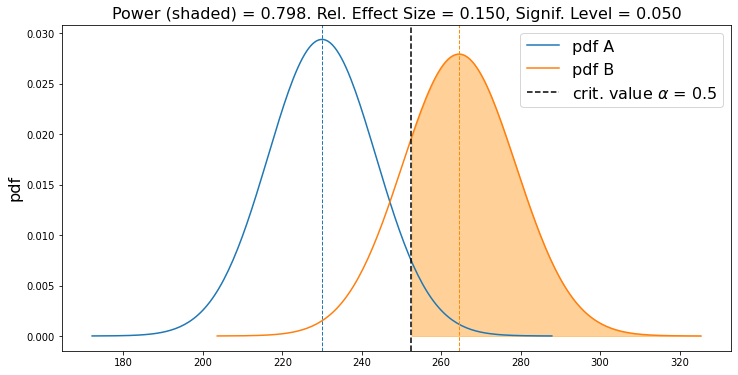

In [ ]:
# sample sizes for the two groups
n_A = n_B = 1150

# proportions of success = conversion rate
p_A = .2  # 20% baseline cr
p_B = .23

# significance level
sl = 0.05

sigma_A = np.sqrt(n_A * p_A * (1 - p_A))
sigma_B = np.sqrt(n_B * p_B * (1 - p_B))

norm_A = stats.norm(loc=p_A * n_A, scale=sigma_A) 
norm_B = stats.norm(loc=p_B * n_B, scale=sigma_B) 

power = abplot(n_A, n_B, norm_A, norm_B, signif_level=sl)

With $n_A = n_B = 1150$ we can proceed with the Z test having a power of $\approx 80\%$ and a significance level of 5%. Time to run the test and see if we reject or fail to reject the Null.

## Two sample Z-test for proportions
Assumptions:
1. The samples in the groups are independently taken
2. The populations of the groups A and B are approximately normal, or the number of sample is sufficiently high for a normal approximation
3. Equal or almost equal variance of the two distributions

Let's state the hypotheses in terms of the average conversion rates (proportions) $p$:
1. $H_0$: there is no difference between the means of conversion rates `p_A` and `p_B`
2. $H_a$: the two proportions are different

In other words:
1. $H_0$: $p_A = p_B$ or $p_A - p_B = p_D = 0$ 
2. $H_1$: $p_A \neq p_B$  or $p_D > 0$


---


The general idea behind the two-sample test is the following. We want to compare two quantities (average proportions "$p$" or average (absolute) number of "successes" "$n$") which we interpret as random variables $X_1$ and $X_2$. The test statistics looks like this:

$$test = \frac{\overbrace{(\bar{X_1} - \bar{X_2})}^{sample\; mean\; diff.} - \overbrace{(\mu_1 - \mu_2)}^{population\; mean\; diff.}}{SE},$$

where $\bar{X}$ is a sample mean of $p$ or $n$ and $\mu$ is the "true mean" that would be true if we had access to the whole population and not just the sample. In practice $\mu_1 - \mu_2 = 0$ if the Null is true. *For proportions* change it to $p_1 - p_2 = 0$. At the denominator we have the *standard error* "SE".

The test statistics for proportions follows a *standard normal* while for means it follows a *T distribution*.

**Test for two independent Proportions**

If the Null is that there is no difference between proportions we use the *pooled* standard error. If we are testing that the difference between proportions is a specific number we use the *non-pooled* standard error. In our example we use the pooled SE:
$$SE = \sqrt{p_{pool}(1-p_{pool})(1/n_A + 1/n_B)},\\
p_{pool} = \frac{p_1 n_1 + p_2 n_2}{n_1 + n_2}
$$

**Test for two independent means**

If the standard deviations of the two distributions for the two groups is similar, we can calculate the SE as the **non-pooled** standard error. For proportions:
$$SE_{unpool} = \sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}.$$
The **pooled** version is:
$$SE_{pool} = \sqrt{\frac{(n_1 - 1)\sigma_1 + (n_2 - 1)\sigma_2}{n_1+n_2 - 2}},$$
where $\sigma$ is the sample standard deviation.

---


 In our case we have proportions. Under the Null, $p_A - p_B = 0$ and the test statistics is calculated with the *pooled* standard error:


$$ Z = \frac{p_A - p_B}{\sqrt{p(1-p)(1/n_A + 1/n_B))}} = \frac{\text{effect size (A/B difference)}}{SE} , \\
p = \frac{p_A\,n_A + p_B \, n_B}{n_A + n_B},$$


where $p_A$ and $p_B$ are the proportions for the two groups and $n_A$ and $n_B$ are the number of samples for each group.

In [ ]:
def two_prop_test(Z, signif_level, power):
  std_norm = stats.norm(loc=0, scale=1)
  x = np.linspace(-5, 5, 200)

  f, ax = plt.subplots(figsize=(12, 6))

  ax.plot(x, std_norm.pdf(x))
  ax.axvline(std_norm.ppf(1 - signif_level), ls='--')
  ax.axvline(std_norm.ppf(signif_level), ls='--')

  argmin = np.argmin(np.abs(std_norm.ppf(1 - signif_level) - x))
  ax.fill_between(x[argmin:], std_norm.pdf(x)[argmin:])

  argmin = np.argmin(np.abs(std_norm.ppf(signif_level) - x))
  ax.fill_between(x[:argmin + 1], std_norm.pdf(x)[:argmin + 1], color='#1f77b4')

  ax.set_title("standard normal", fontsize=16)
  ax.set_ylabel("pdf", fontsize=16)

  ax.axvline(Z, color='k', label="Z = {:1.3f}".format(Z))
  ax.legend(fontsize=16);

  lower_crit = std_norm.ppf(signif_level)
  higher_crit = std_norm.ppf(1 - signif_level)
  print("Two tailed Two sample Z-test for proportions.")
  if Z < lower_crit:
    print("Test Statistics = {:1.3f},  critical value= {:1.3f}".format(Z, lower_crit))
    print("Reject the Null at {:1.3f} significance level with power = {:1.3f}".format(sl, power))
    print("The two proportions are different in a statistically significant manner")
    print("")
  elif Z > higher_crit:
    print("Test Statistics = {:1.3f},  critical value= {:1.3f}".format(Z, higher_crit))
    print("Reject the Null at {:1.3f} significance level with power = {:1.3f}".format(sl, power))
    print("The two proportions are different in a statistically significant manner")
    print("")
  else:
    print("Test Statistics = {:1.3f},  critical value= {:1.3f}".format(Z, lower_crit))
    print("Fail to reject the Null at {:1.3f} significance level with power = {:1.3f}".format(sl, power))
    print("The two proportions are not different in a statistically significant manner")
    print("")

Two tailed Two sample Z-test for proportions.
Test Statistics = -1.751,  critical value= -1.645
Reject the Null at 0.050 significance level with power = 0.798
The two proportions are different in a statistically significant manner



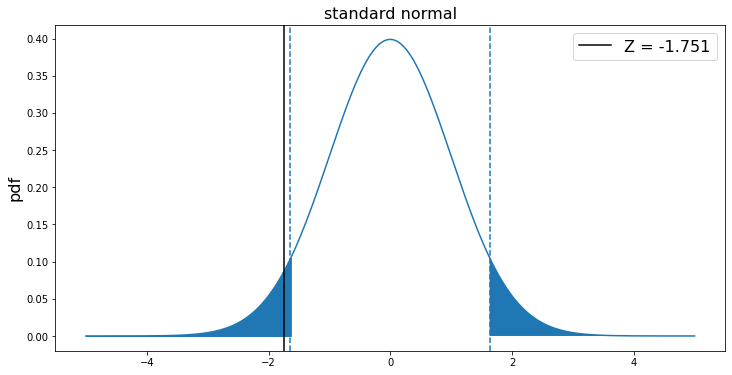

In [ ]:
# sample sizes for the two groups
n_A = n_B = 1150

# proportions of success = conversion rate
p_A = .2  # 20% baseline cr
p_B = .23

# significance level
sl = 0.05

p_pool = (p_A * n_A + p_B * n_B)/(n_A + n_B)
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_A + 1/n_B))
Z = (p_A - p_B) / se

two_prop_test(Z, sl, power)

**We detect the effect with statistical significance**. If we try with smaller sample sizes we get

Two tailed Two sample Z-test for proportions.
Test Statistics = -1.460,  critical value= -1.645
Fail to reject the Null at 0.050 significance level with power = 0.674
The two proportions are not different in a statistically significant manner



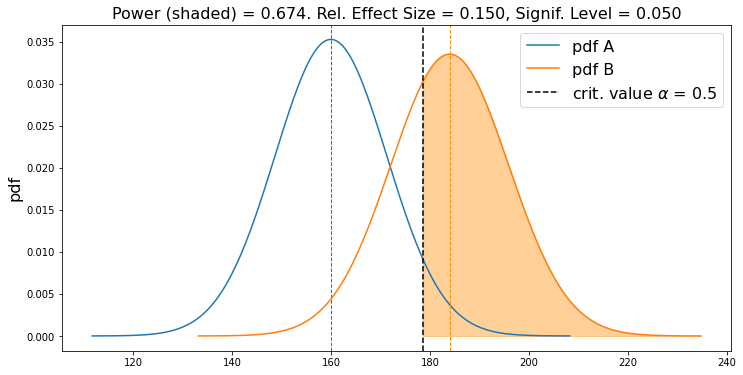

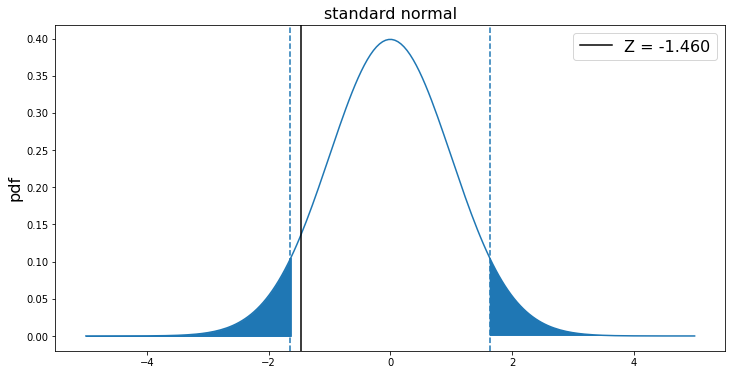

In [ ]:
# sample sizes for the two groups
n_A = n_B = 800

# proportions of success = conversion rate
p_A = .2
p_B = .23

# significance level
sl = 0.05

p_hat = (p_A * n_A + p_B * n_B)/(n_A + n_B)
se = np.sqrt(p_hat * (1 - p_hat) * (1/n_A + 1/n_B))
Z = (p_A - p_B) / se

sigma_A = np.sqrt(n_A * p_A * (1 - p_A))
sigma_B = np.sqrt(n_B * p_B * (1 - p_B))

norm_A = stats.norm(loc=p_A * n_A, scale=sigma_A) 
norm_B = stats.norm(loc=p_B * n_B, scale=sigma_B) 

power = abplot(n_A, n_B, norm_A, norm_B, signif_level=sl)
two_prop_test(Z, sl, power)

**We fail to detect the effect!**. The power is also reduced because the sample size is smaller.

## Minimum Detectable Effect Size
Keeping the significance level at 0.05 and power at $\approx 80\%$, if we want to detect a minimum relative effect of 5%, what are the sample sizes that we need to have a significant test?



Two tailed Two sample Z-test for proportions.
Test Statistics = -1.752,  critical value= -1.645
Reject the Null at 0.050 significance level with power = 0.798
The two proportions are different in a statistically significant manner



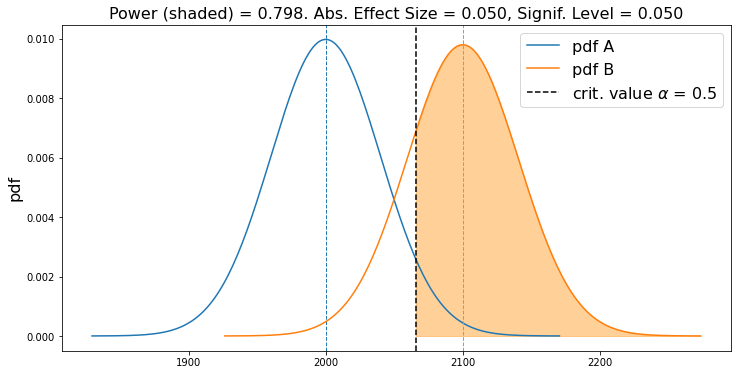

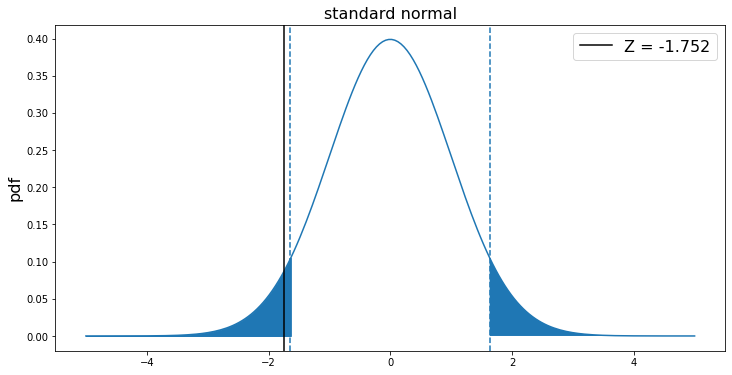

In [ ]:
# sample sizes for the two groups
n_A = n_B = 10000

# proportions of success = conversion rate
p_A = .2
p_B = .21

# significance level
sl = 0.05

p_hat = (p_A * n_A + p_B * n_B)/(n_A + n_B)
se = np.sqrt(p_hat * (1 - p_hat) * (1/n_A + 1/n_B))
Z = (p_A - p_B) / se

sigma_A = np.sqrt(n_A * p_A * (1 - p_A))
sigma_B = np.sqrt(n_B * p_B * (1 - p_B))

norm_A = stats.norm(loc=p_A * n_A, scale=sigma_A) 
norm_B = stats.norm(loc=p_B * n_B, scale=sigma_B) 

power = abplot(n_A, n_B, norm_A, norm_B, signif_level=sl)
two_prop_test(Z, sl, power)

**We need about 10k samples per group** to detect a 0.05 effect with a power of $\approx 80\%$ at 5% significance.


# Bayesian approach with MCMC
We model the number of conversion with a $c\; \text{~}\; Binomial(n, p)$ allowing the probability of conversion to be sampled from a $p \;\text{~}\;Beta(\alpha, \beta)$ prior.

In [ ]:
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import arviz

In [ ]:
!pip uninstall -y pymc3

Uninstalling pymc3-3.7:
  Successfully uninstalled pymc3-3.7


In [ ]:
!pip install pymc3

First we need to simulate the visitors using versions A and B


In [ ]:
n_A = n_B = 1150
cr_A = .2
cr_B = .23

distr_A = stats.bernoulli(p=cr_A)
distr_B = stats.bernoulli(p=cr_B)
samp_A = distr_A.rvs(size=n_A)
samp_B = distr_B.rvs(size=n_B)

In [ ]:
print("conv. rate A = {:1.3f}".format(sum(samp_A)/len(samp_A)))
print("conv. rate B = {:1.3f}".format(sum(samp_B)/len(samp_B)))

conv. rate A = 0.205
conv. rate B = 0.243


In [ ]:
with pm.Model() as model:
  pA = pm.Beta('pA', alpha=1, beta=1)
  pB = pm.Beta('pB', alpha=1, beta=1)
  d = pm.Deterministic('d', pB - pA)
  obsA = pm.Bernoulli('obsA', p=pA, observed=samp_A)
  obsB = pm.Bernoulli('obsB', p=pB, observed=samp_B)

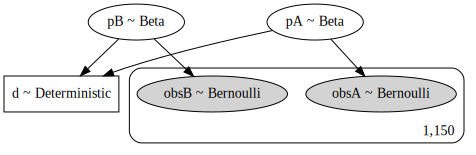

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
with model:
  trace = pm.sample(draws=20000, chains=2, tune=3000, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [pB, pA]
Sampling chain 1, 0 divergences: 100%|██████████| 23000/23000 [00:16<00:00, 1379.24it/s]


In [ ]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
pA,0.206,0.012,0.183,0.228,0.0,0.0,31474.0,31334.0,31512.0,28529.0,1.0
pB,0.243,0.013,0.219,0.267,0.0,0.0,31935.0,31935.0,31907.0,26576.0,1.0
d,0.037,0.017,0.005,0.070,0.0,0.0,31498.0,30856.0,31463.0,28023.0,1.0


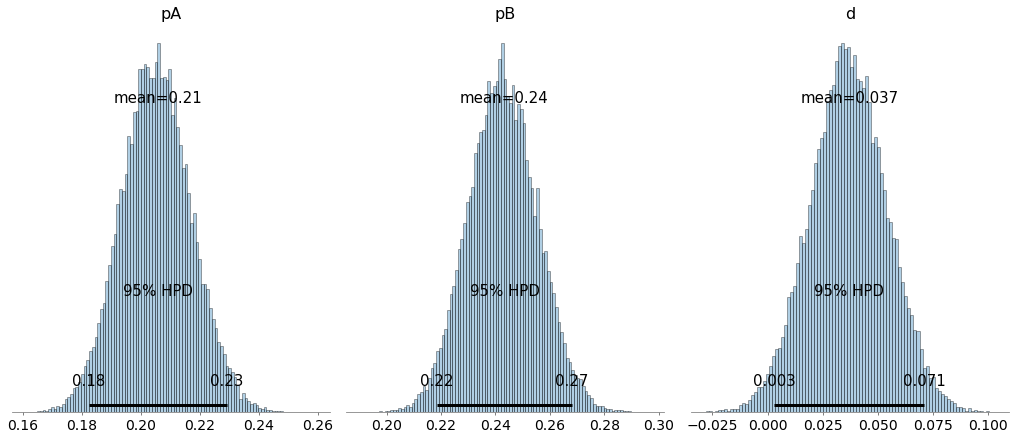

In [ ]:
pm.plot_posterior(trace, credible_interval=0.95, kind='hist', edgecolor='k', figsize=(14, 6));

In [ ]:
print("Probability site A is BETTER than site B: {}".format((trace['d'] < 0).mean()))
print("Probability site A is WORSE than site B: {}".format((trace['d'] > 0).mean()))

Probability site A is BETTER than site B: 0.016
Probability site A is WORSE than site B: 0.984


The result of the frequentist approach is confirmed, version B is better.